# Class 1: Genomic Sequence Analysis with Python

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/duttaprat/BMI_503/blob/main/Class1_Genomics/notebook1_genomics_sequence_analysis.ipynb)

**Course**: BMI 503 - Introduction to Computer Science for Biomedical Informatics  
**Instructors**: Pratik Dutta   
**Institution**: Stony Brook University

---

## Learning Objectives

1. Use **Biopython** for sequence manipulation
2. Work with **pysam** for alignment files (BAM/SAM)
3. Analyze variants using **PyVCF**
4. Manipulate genomic intervals with **pybedtools**
5. Use **scikit-bio** for sequence analysis
6. Visualize data with **matplotlib/seaborn**
7. Process data with **pandas**

## Setup & Installation

In [1]:
# Install packages
!pip install biopython pysam PyVCF3 scikit-bio pandas matplotlib seaborn -q
!apt-get install -y bedtools -qq
!pip install pybedtools -q
print("✅ Installation complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 988.6/988.6 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 67.7 MB/s eta 0:00:00
Selecting previously unselected package bedtools.
(Reading database ... 125080 files and directories currently installed.)
Preparing to unpack .../bedtools_2.30.0+dfsg-2ubuntu0.1_amd64.deb ...
Unpacking bedtools (2.30.0+dfsg-2ubuntu0.1) ...
Setting up bedtools (2.30.0+dfsg-2ubuntu0.1) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 95.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✅ Installation compl

In [2]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

from Bio import SeqIO, Entrez, SeqUtils
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import pysam
import vcf
import pybedtools
import skbio
from skbio import DNA, RNA, Protein
from skbio.sequence.distance import hamming
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
print("📦 Libraries imported!")

📦 Libraries imported!


---
## Part 1: Biopython

In [3]:
# Basic sequence operations
dna = Seq("ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG")
print(f"DNA: {dna}")
print(f"Complement: {dna.complement()}")
print(f"Reverse Complement: {dna.reverse_complement()}")
print(f"RNA: {dna.transcribe()}")
print(f"Protein: {dna.transcribe().translate()}")
print(f"GC Content: {SeqUtils.gc_fraction(dna)*100:.2f}%")

DNA: ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG
Complement: TACCGGTAACATTACCCGGCGACTTTCCCACGGGCTATC
Reverse Complement: CTATCGGGCACCCTTTCAGCGGCCCATTACAATGGCCAT
RNA: AUGGCCAUUGUAAUGGGCCGCUGAAAGGGUGCCCGAUAG
Protein: MAIVMGR*KGAR*
GC Content: 56.41%





### Step-by-Step Breakdown:

**Original DNA:**
```
ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG
```

**Step 1: `dna.transcribe()`** - DNA → RNA
```
AUGGCCAUUGUAAUGGGCCGCUGAAAGGGUGCCCGAUAG
```
- T → U (Thymine becomes Uracil)
- Everything else stays the same

**Step 2: `.translate()`** - RNA → Protein

The genetic code reads RNA in **triplets (codons)**:

| Codon | Amino Acid | Letter Code |
|-------|------------|-------------|
| **AUG** | Methionine | **M** (Start codon) |
| **GCC** | Alanine | **A** |
| **AUU** | Isoleucine | **I** |
| **GUA** | Valine | **V** |
| **AUG** | Methionine | **M** |
| **GGC** | Glycine | **G** |
| **CGC** | Arginine | **R** |
| **UGA** | **STOP** | **\*** |
| AAG | Lysine | K |
| GGU | Glycine | G |
| GCC | Alanine | A |
| CGA | Arginine | R |
| UAG | **STOP** | **\*** |

**Result:**
```
M  A  I  V  M  G  R  *  K  G  A  R  *
```

**Full output:**
```
Protein: MAIVMGR*KGAR*
```

In [11]:
# Download from NCBI
Entrez.email = "your.email@example.com"
handle = Entrez.efetch(db="nucleotide", id="NM_000546", rettype="fasta", retmode="text")
record = SeqIO.read(handle, "fasta")
handle.close()
print(f"Downloaded: {record.description[:6000]}")
print(f"Length: {len(record.seq)} bp")
print(f"First 100 bp: " + str(record.seq[:100]))

Downloaded: NM_000546.6 Homo sapiens tumor protein p53 (TP53), transcript variant 1, mRNA
Length: 2512 bp
First 100 bp: CTCAAAAGTCTAGAGCCACCGTCCAGGGAGCAGGTAGCTGCTGGGCTCCGGGGACACTTTGCGTTCGGGCTGGGAGCGTGCTTTCCACGACGGTGACACG


## Part 2: Working with Alignment Files - SAM and BAM

### What are SAM and BAM files?

When DNA sequencing is performed, millions of short DNA sequences (called **reads**) are generated. These reads need to be **aligned** or **mapped** to a reference genome to determine where each read came from in the genome.

**SAM** (Sequence Alignment/Map) and **BAM** (Binary Alignment/Map) files store this alignment information.

---

### SAM vs BAM

| Feature | SAM | BAM |
|---------|-----|-----|
| **Format** | Text (human-readable) | Binary (compressed) |
| **File Size** | Large (1-10 GB) | Small (100 MB - 1 GB) |
| **Speed** | Slow to process | Fast to process |
| **Use Case** | Viewing, debugging | Storage, analysis |
| **Extension** | `.sam` | `.bam` |

**Key Point**: BAM is just a compressed binary version of SAM. They contain the same information!

---

### What Information Do They Store?

Each alignment (read) contains:

1. **Read ID**: Unique identifier for the sequenced fragment
2. **Chromosome/Reference**: Which chromosome the read mapped to (e.g., chr1, chr2)
3. **Position**: Exact genomic position where the read aligns (e.g., position 12345)
4. **Mapping Quality**: How confident we are about this alignment (0-60 score)
5. **CIGAR String**: Describes the alignment (matches, insertions, deletions)
6. **Sequence**: The actual DNA sequence of the read
7. **Quality Scores**: Quality of each base call
8. **Flags**: Information about pairing, strand, etc.

---

### Example: What Does a SAM File Look Like?
```
@HD	VN:1.0	SO:coordinate
@SQ	SN:chr1	LN:249250621
read1	0	chr1	12345	60	50M	*	0	0	ATCGATCG...	IIIIIIII...
read2	16	chr1	12350	60	50M	*	0	0	GCTAGCTA...	IIIIIIII...
```

**Line-by-line explanation:**
- **@HD**: Header line (version info)
- **@SQ**: Reference sequence info (chromosome name and length)
- **read1, read2**: Actual alignment records

---

### Why Do We Need SAM/BAM Files?

SAM/BAM files are essential for:

1. **Variant Calling**: Finding SNPs, insertions, deletions
2. **RNA-seq Analysis**: Measuring gene expression levels
3. **ChIP-seq**: Identifying protein-DNA binding sites
4. **Coverage Analysis**: How well each genomic region is sequenced
5. **Quality Control**: Assessing sequencing and alignment quality

---

### Common Workflow
```
FASTQ files (raw reads)
        ↓
    Alignment Tool (BWA, Bowtie2)
        ↓
    SAM file (text output)
        ↓
    Convert to BAM (samtools)
        ↓
    BAM file (compressed, indexed)
        ↓
    Analysis (variant calling, coverage, etc.)
```

---

### BAM File Index (.bai)

BAM files are often paired with an **index file** (`.bam.bai`) that allows:
- **Fast random access** to specific genomic regions
- **Quick retrieval** of reads without scanning the entire file
- **Efficient visualization** in genome browsers

**Without index**: Must scan entire file sequentially (slow!)  
**With index**: Jump directly to region of interest (fast!)

---

### Tools for Working with SAM/BAM

| Tool | Purpose |
|------|---------|
| **samtools** | Swiss-army knife for SAM/BAM manipulation |
| **pysam** | Python interface to SAM/BAM files |
| **IGV** | Visualization tool (Integrative Genomics Viewer) |
| **Picard** | Java tools for SAM/BAM processing |

---

### What We'll Learn with Pysam

Using the `pysam` Python library, you'll learn to:

1. ✅ Open and read BAM files
2. ✅ Extract alignment information (chromosome, position, quality)
3. ✅ Calculate coverage (how many reads cover each position)
4. ✅ Filter reads based on quality or mapping
5. ✅ Count total mapped reads

Let's dive into the code! 👇

In [17]:
# Small BAM file from 1000 Genomes
!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/HG00096/alignment/HG00096.chrom20.ILLUMINA.bwa.GBR.low_coverage.20120522.bam -O sample.bam


--2025-11-02 18:03:25--  ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/HG00096/alignment/HG00096.chrom20.ILLUMINA.bwa.GBR.low_coverage.20120522.bam
           => ‘sample.bam’
Resolving ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)... 193.62.193.167
Connecting to ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)|193.62.193.167|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /vol1/ftp/phase3/data/HG00096/alignment ... done.
==> SIZE HG00096.chrom20.ILLUMINA.bwa.GBR.low_coverage.20120522.bam ... 318238352
==> PASV ... done.    ==> RETR HG00096.chrom20.ILLUMINA.bwa.GBR.low_coverage.20120522.bam ... done.
Length: 318238352 (303M) (unauthoritative)

HG00096.chrom20.ILL 100%[===================>] 303.50M  28.6MB/s    in 11s     

2025-11-02 18:03:38 (26.5 MB/s) - ‘sample.bam’ saved [318238352]



In [18]:
pysam.index("sample.bam")

# Now you can use it
bam = pysam.AlignmentFile("sample.bam", "rb")
print(f"References: {bam.references}")
print(f"Total reads: {bam.count()}")
bam.close()

References: ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', 'MT', 'GL000207.1', 'GL000226.1', 'GL000229.1', 'GL000231.1', 'GL000210.1', 'GL000239.1', 'GL000235.1', 'GL000201.1', 'GL000247.1', 'GL000245.1', 'GL000197.1', 'GL000203.1', 'GL000246.1', 'GL000249.1', 'GL000196.1', 'GL000248.1', 'GL000244.1', 'GL000238.1', 'GL000202.1', 'GL000234.1', 'GL000232.1', 'GL000206.1', 'GL000240.1', 'GL000236.1', 'GL000241.1', 'GL000243.1', 'GL000242.1', 'GL000230.1', 'GL000237.1', 'GL000233.1', 'GL000204.1', 'GL000198.1', 'GL000208.1', 'GL000191.1', 'GL000227.1', 'GL000228.1', 'GL000214.1', 'GL000221.1', 'GL000209.1', 'GL000218.1', 'GL000220.1', 'GL000213.1', 'GL000211.1', 'GL000199.1', 'GL000217.1', 'GL000216.1', 'GL000215.1', 'GL000205.1', 'GL000219.1', 'GL000224.1', 'GL000223.1', 'GL000195.1', 'GL000212.1', 'GL000222.1', 'GL000200.1', 'GL000193.1', 'GL000194.1', 'GL000225.1', 'GL000192.1', 'NC_007605', 'hs37d5')

---
## Part 3: PyVCF (Variants)

In [19]:
# Download VCF
!wget https://raw.githubusercontent.com/jamescasbon/PyVCF/master/vcf/test/example-4.0.vcf -O sample.vcf

vcf_reader = vcf.Reader(open('sample.vcf', 'r'))
print(f"Samples: {vcf_reader.samples}")

for i, record in enumerate(vcf_reader):
    if i >= 3: break
    print(f"{record.CHROM}:{record.POS} {record.REF}>{record.ALT[0]} Q={record.QUAL}")

--2025-11-02 18:12:06--  https://raw.githubusercontent.com/jamescasbon/PyVCF/master/vcf/test/example-4.0.vcf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1605 (1.6K) [text/plain]
Saving to: ‘sample.vcf’

sample.vcf          100%[===================>]   1.57K  --.-KB/s    in 0s      

2025-11-02 18:12:06 (16.1 MB/s) - ‘sample.vcf’ saved [1605/1605]

Samples: ['NA00001', 'NA00002', 'NA00003']
20:14370 G>A Q=29
20:17330 T>A Q=3.0
20:1110696 A>G Q=1000.0


In [25]:
df= pd.read_csv("sample.vcf", sep='\t', comment='#', header=None)
# You can manually assign column names (standard VCF fields)
df.columns = [
    "CHROM", "POS", "ID", "REF", "ALT",
    "QUAL", "FILTER", "INFO", "FORMAT",
    "Sample1", "Sample2", "Sample3"
]

df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,Sample1,Sample2,Sample3
0,20,14370,rs6054257,G,A,29,PASS,NS=3;DP=14;AF=0.5;DB;H2,GT:GQ:DP:HQ,"0|0:48:1:51,51","1|0:48:8:51,51","1/1:43:5:.,."
1,20,17330,.,T,A,3.0,q10,NS=3;DP=11;AF=0.017,GT:GQ:DP:HQ,"0|0:49:3:58,50","0|1:3:5:65,3",0/0:41:3
2,20,1110696,rs6040355,A,"G,T",1e+03,PASS,"NS=2;DP=10;AF=0.333,0.667;AA=T;DB",GT:GQ:DP:HQ,"1|2:21:6:23,27","2|1:2:0:18,2",2/2:35:4
3,20,1230237,.,T,.,47,PASS,NS=3;DP=13;AA=T,GT:GQ:DP:HQ,"0|0:54:7:56,60","0|0:48:4:51,51",0/0:61:2
4,20,1231234,.,AT,A,46,PASS,NS=3;DP=15;AA=A,GT:GQ:DP:HQ,"1|1:23:7:26,30","0|0:27:9:56,60","0|0:31:10:65,71"
5,20,1234567,microsat1,GTCT,"G,GTACT",.,PASS,NS=3;DP=9;AA=G,GT:GQ:DP,./.:35:4,0/2:17:2,1/1:40:3


---
## Part 4: Pybedtools

In [27]:
# Create BED files
with open('features.bed', 'w') as f:
    f.write("chr1\t100\t200\tfeature1\n")
    f.write("chr1\t300\t400\tfeature2\n")
    f.write("chr1\t500\t600\tfeature2\n")

with open('genes.bed', 'w') as f:
    f.write("chr1\t150\t250\tgene1\n")
    f.write("chr1\t350\t450\tgene1\n")

features = pybedtools.BedTool('features.bed')
genes = pybedtools.BedTool('genes.bed')
intersect = features.intersect(genes)
print("Intersections:")
print(intersect)

Intersections:
chr1	150	200	feature1
chr1	350	400	feature2



---
## Part 5: Scikit-bio

In [30]:
# Sequence analysis
seq = DNA('ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG')
print(f"Sequnce len: {len(seq)}")
print(f"GC content: {seq.gc_content():.2%}")
print(f"Reverse complement: {seq.reverse_complement()}")

# k-mers
kmers = list(seq.iter_kmers(3))
print(f"\nTotal 3-mers: {len(kmers)}")
kmer_counts = Counter(str(k) for k in kmers)
print(f"Most common: {kmer_counts.most_common(3)}")

kmers = list(seq.iter_kmers(6))
print(f"\nTotal 6-mers: {len(kmers)}")
kmer_counts = Counter(str(k) for k in kmers)
print(f"Most common: {kmer_counts.most_common(6)}")

Sequnce len: 39
GC content: 56.41%
Reverse complement: CTATCGGGCACCCTTTCAGCGGCCCATTACAATGGCCAT

Total 3-mers: 37
Most common: [('GCC', 3), ('ATG', 2), ('TGG', 2)]

Total 6-mers: 34
Most common: [('ATGGCC', 1), ('TGGCCA', 1), ('GGCCAT', 1), ('GCCATT', 1), ('CCATTG', 1), ('CATTGT', 1)]


---
## Part 6: Pandas

In [31]:
# Genomic dataframe
data = {
    'Gene': ['GENE1', 'GENE2', 'GENE3'],
    'Chr': ['chr1', 'chr1', 'chr2'],
    'Start': [1000, 5000, 2000],
    'End': [2000, 6500, 3500],
    'Expression': [45.2, 123.5, 67.8]
}
df = pd.DataFrame(data)
df['Length'] = df['End'] - df['Start']
print(df)
print(f"\nMean expression: {df['Expression'].mean():.2f}")

    Gene   Chr  Start   End  Expression  Length
0  GENE1  chr1   1000  2000        45.2    1000
1  GENE2  chr1   5000  6500       123.5    1500
2  GENE3  chr2   2000  3500        67.8    1500

Mean expression: 78.83


---
## Part 7: Visualization

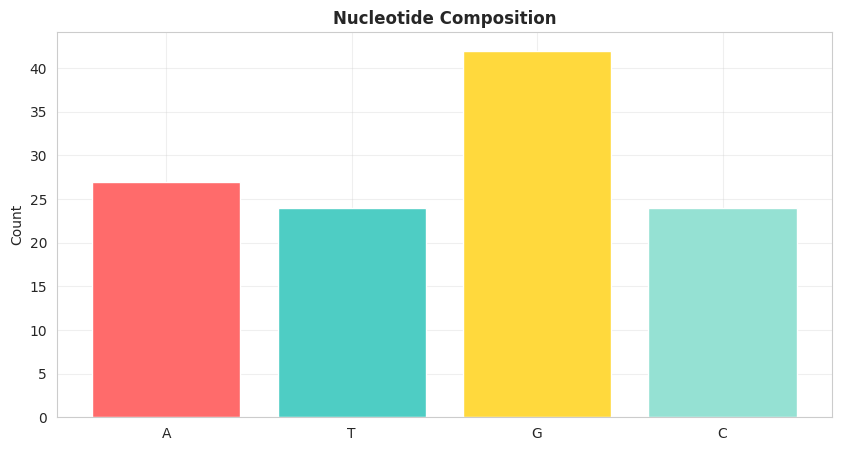

In [32]:
# Nucleotide composition
seq = Seq("ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG" * 3)
counts = [seq.count(n) for n in ['A', 'T', 'G', 'C']]

plt.figure(figsize=(10, 5))
plt.bar(['A', 'T', 'G', 'C'], counts, color=['#FF6B6B', '#4ECDC4', '#FFD93D', '#95E1D3'])
plt.title('Nucleotide Composition', fontweight='bold')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.show()

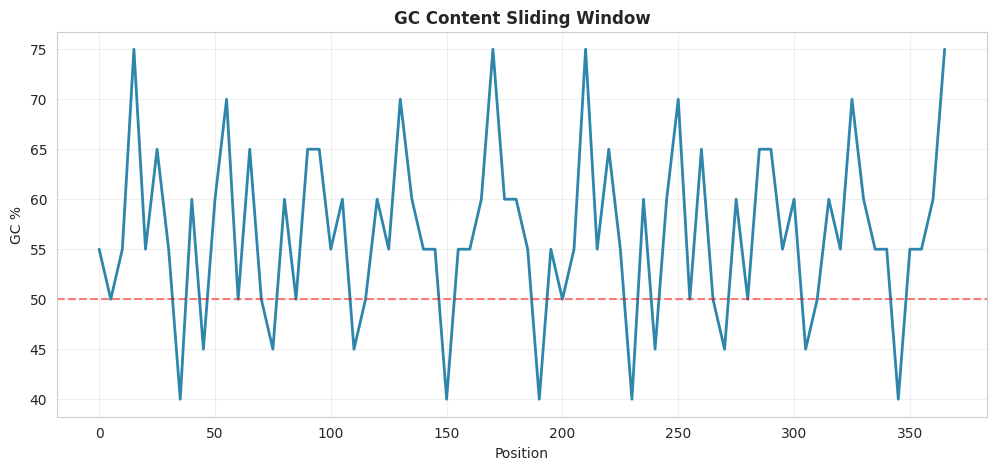

In [33]:
# GC content sliding window
sequence = Seq("ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG" * 10)
window = 20
positions, gc_vals = [], []

for i in range(0, len(sequence)-window, 5):
    win = sequence[i:i+window]
    positions.append(i)
    gc_vals.append(SeqUtils.gc_fraction(win) * 100)

plt.figure(figsize=(12, 5))
plt.plot(positions, gc_vals, linewidth=2, color='#2E86AB')
plt.axhline(50, color='red', linestyle='--', alpha=0.5)
plt.title('GC Content Sliding Window', fontweight='bold')
plt.xlabel('Position')
plt.ylabel('GC %')
plt.grid(alpha=0.3)
plt.show()

---
## Complete Workflow Example

In [34]:
print("="*60)
print("COMPLETE GENOMIC ANALYSIS WORKFLOW")
print("="*60)

# 1. Download sequence
print("\n[1] Downloading TP53 from NCBI...")
Entrez.email = "your.email@example.com"
handle = Entrez.efetch(db="nucleotide", id="NM_000546", rettype="fasta", retmode="text")
record = SeqIO.read(handle, "fasta")
handle.close()
print(f"✅ {record.description[:50]}... ({len(record.seq)} bp)")

# 2. Analyze
print("\n[2] Analyzing sequence properties...")
gc = SeqUtils.gc_fraction(record.seq) * 100
print(f"✅ GC Content: {gc:.2f}%")

# 3. Find motifs
print("\n[3] Finding TATA boxes...")
tata_pos = [i for i in range(len(record.seq)-6) if record.seq[i:i+6] == "TATAAA"]
print(f"✅ Found {len(tata_pos)} TATA box(es)")

# 4. k-mers
print("\n[4] Generating k-mers...")
dna_skbio = DNA(str(record.seq[:100]))
kmers = list(dna_skbio.iter_kmers(3))
print(f"✅ Generated {len(kmers)} 3-mers")

# 5. Create dataframe
print("\n[5] Creating summary dataframe...")
summary = pd.DataFrame({
    'Gene': ['TP53'],
    'Length': [len(record.seq)],
    'GC%': [gc],
    'TATA_boxes': [len(tata_pos)]
})
print(summary)

print("\n✅ Workflow complete!")
print("="*60)

COMPLETE GENOMIC ANALYSIS WORKFLOW

[1] Downloading TP53 from NCBI...
✅ NM_000546.6 Homo sapiens tumor protein p53 (TP53),... (2512 bp)

[2] Analyzing sequence properties...
✅ GC Content: 53.38%

[3] Finding TATA boxes...
✅ Found 0 TATA box(es)

[4] Generating k-mers...
✅ Generated 98 3-mers

[5] Creating summary dataframe...
   Gene  Length        GC%  TATA_boxes
0  TP53    2512  53.383758           0

✅ Workflow complete!


---
## Exercises

### Exercise 1: Sequence Analysis
Download BRCA1 (NM_007294) and calculate GC content, find ATG positions

In [ ]:
# Your code here


### Exercise 2: VCF Analysis
Filter variants with quality > 50 and create a pandas DataFrame

In [ ]:
# Your code here


### Exercise 3: k-mer Analysis  
Generate 4-mers and find the most frequent k-mer

In [ ]:
# Your code here


---
## Summary


- ✅ Biopython for sequences
- ✅ Pysam for BAM files
- ✅ PyVCF for variants
- ✅ Pybedtools for intervals
- ✅ Scikit-bio for analysis
- ✅ Pandas for data
- ✅ Matplotlib/Seaborn for viz

### Resources
- [Biopython](http://biopython.org)
- [Pysam Docs](https://pysam.readthedocs.io)
- [NCBI](https://www.ncbi.nlm.nih.gov)